In [1]:
from svd_tool import plot_singular_cum
from svd_tool import plot_ce_index
from svd_tool import analysis_u
from svd_tool import macro_analysis
from svd_tool import micro_analysis_jac
from svd_tool import micro_analysis_ig
from svd_tool import dgbd_ce

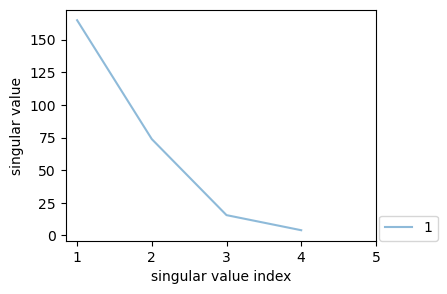

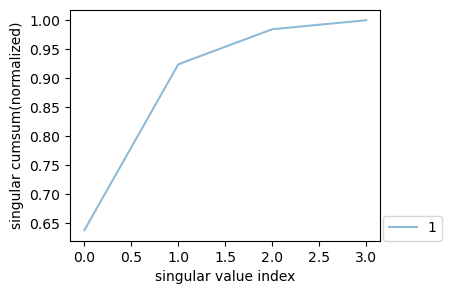

In [19]:
test_id = 'long_term_forecast_sir_review_NN_cov_samp9000_sigma0.1_rho-0.5_lam1_dmodel128_'
start = 1
end = 54000
interval = 54000
seq_len = 1

gn, gn_std, singular, us, vts, mats, Sigs = plot_singular_cum(test_id, eps='all', seed = 1, start=start, end=end, interval=interval, log_bool=False)
# dgbd_ce(singular, start, end, interval, seed=1)

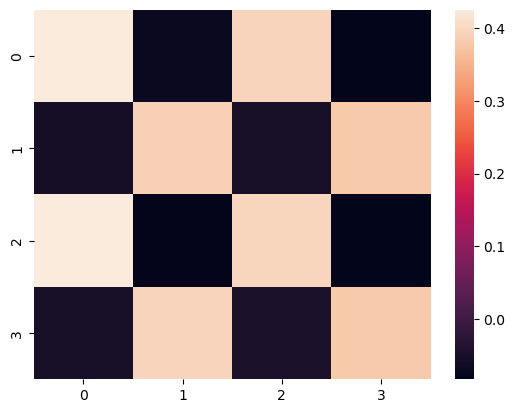

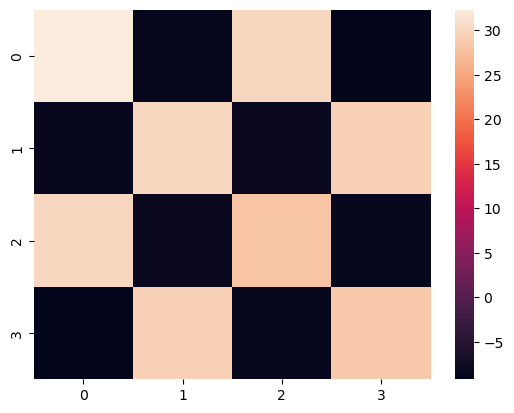

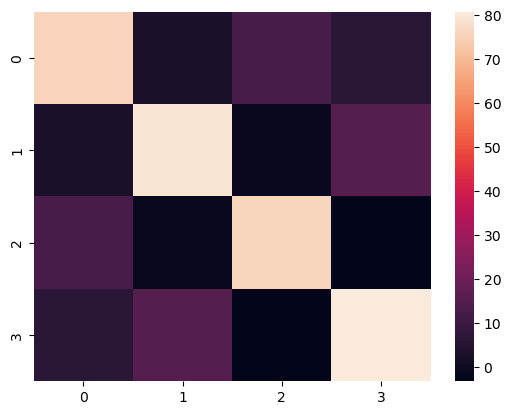

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.heatmap(mats[1][0])
plt.show()
ASA = mats[1][0].T @ np.linalg.inv(Sigs[1][0]) @ mats[1][0]
sns.heatmap(ASA)
plt.show()
sns.heatmap(np.linalg.inv(Sigs[1][0]))
plt.show()


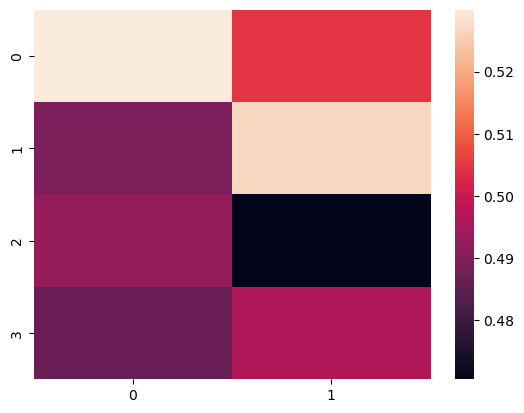

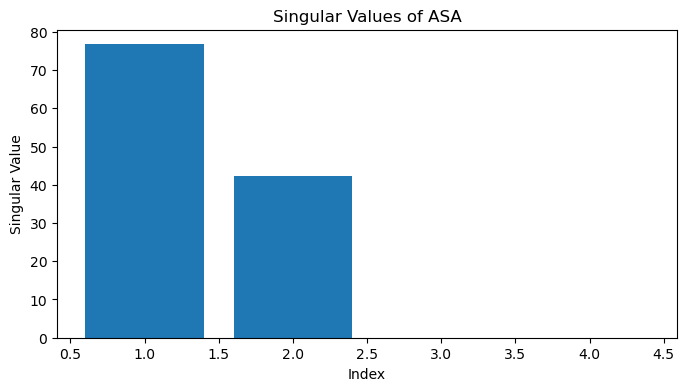

In [24]:
U, S, VT = np.linalg.svd(ASA)
sns.heatmap(np.abs(U)[:,:2])
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(S)+1), S)
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of ASA')
plt.show()

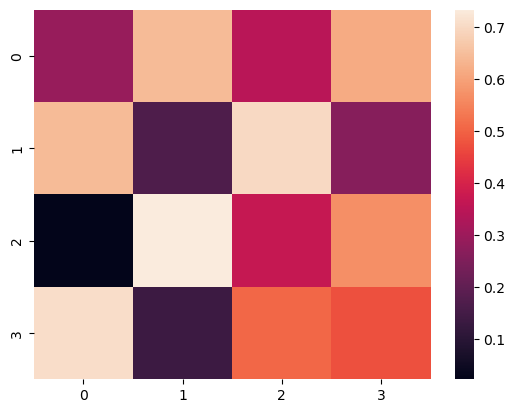

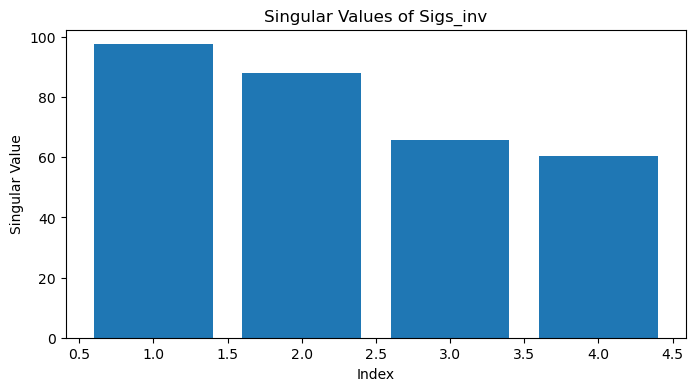

In [23]:
U, S, VT = np.linalg.svd(np.linalg.inv(Sigs[1][0]))
sns.heatmap(np.abs(U))
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(S)+1), S)
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Sigs_inv')
plt.show()

<AxesSubplot:>

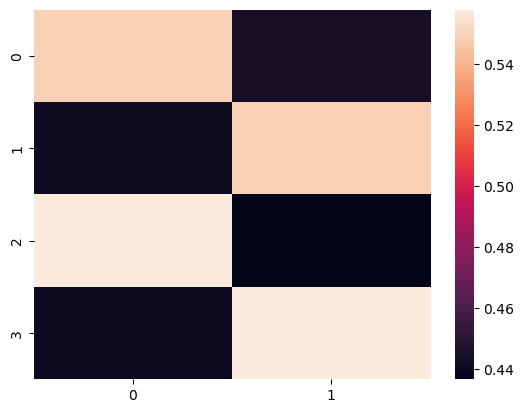

In [25]:
U, S, VT = np.linalg.svd(mats[1][0])
sns.heatmap(np.abs(U)[:,:2])

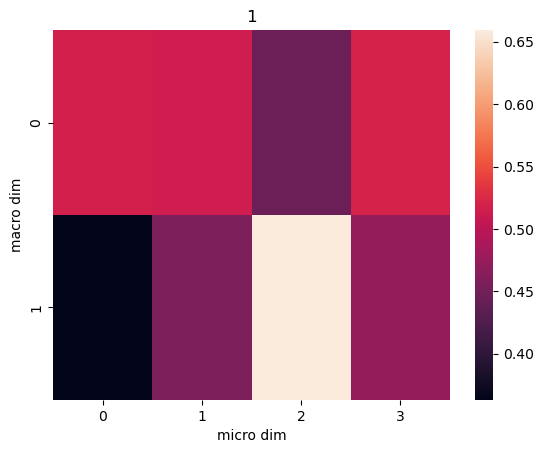

In [12]:
analysis_u(us, seq_len=1, dims=4, start=start, end=end, interval=interval, space_only=True)

# old results

In [6]:
mul_batch_size = [0,5000,3000,1000]#[0,10,4500,1500]
sigma = 0.03
rou = -0.5
steps = 7
dt = 0.01

seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
spring = Simple_Spring_Model(device=device)
test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) 
train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)

train_data=train_data
test_data=test_data
ss,sps,ls,lps = train_data

# 参数设置  
input_size = ss.shape[1]    # 输入维度  
hidden_size = 128  
output_size = sps.shape[1]  # 输出维度（多元高斯分布的维度）  
learning_rate = 0.001  
num_epochs = 500  
batch_size = 100

# 生成随机数据  
X = ss  # 1000 个样本  
Y = sps  # 对应的输出  

# 初始化模型、损失函数和优化器  
model = MultivariateGaussianModel(input_size, hidden_size, output_size,device=device)  
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  

# 自定义多元高斯分布的负对数似然损失函数  
def nll_loss(mu, L, y):  
    # 计算协方差矩阵 Sigma = L L^T  
    Sigma = torch.matmul(L, L.transpose(1, 2))  
    # 计算多元高斯分布的负对数似然  
    mvn = dist.MultivariateNormal(loc=mu, scale_tril=L)  
    return -mvn.log_prob(y)  

# 训练模型  
for epoch in range(num_epochs):  
    for i in range(0, len(X), batch_size):  
        inputs = X[i:i+batch_size]  
        labels = Y[i:i+batch_size]  

        # 前向传播  
        mu, L = model(inputs)  
        loss = nll_loss(mu, L, labels).mean()  

        # 反向传播和优化  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')  


Epoch [1/500], Loss: -7.5011
Epoch [2/500], Loss: -7.5199
Epoch [3/500], Loss: -7.5573
Epoch [4/500], Loss: -7.6574
Epoch [5/500], Loss: -7.6897
Epoch [6/500], Loss: -7.7041
Epoch [7/500], Loss: -7.7256
Epoch [8/500], Loss: -7.7277
Epoch [9/500], Loss: -7.7341
Epoch [10/500], Loss: -7.7383
Epoch [11/500], Loss: -7.7453
Epoch [12/500], Loss: -7.7642
Epoch [13/500], Loss: -7.7845
Epoch [14/500], Loss: -7.8024
Epoch [15/500], Loss: -7.8097
Epoch [16/500], Loss: -7.8058
Epoch [17/500], Loss: -7.7925
Epoch [18/500], Loss: -7.7850
Epoch [19/500], Loss: -7.7809
Epoch [20/500], Loss: -7.7812
Epoch [21/500], Loss: -7.7789
Epoch [22/500], Loss: -7.7858
Epoch [23/500], Loss: -7.8004
Epoch [24/500], Loss: -7.8187
Epoch [25/500], Loss: -7.8278
Epoch [26/500], Loss: -7.8343
Epoch [27/500], Loss: -7.8460
Epoch [28/500], Loss: -7.8589
Epoch [29/500], Loss: -7.8629
Epoch [30/500], Loss: -7.8679
Epoch [31/500], Loss: -7.8725
Epoch [32/500], Loss: -7.8742
Epoch [33/500], Loss: -7.8735
Epoch [34/500], Los

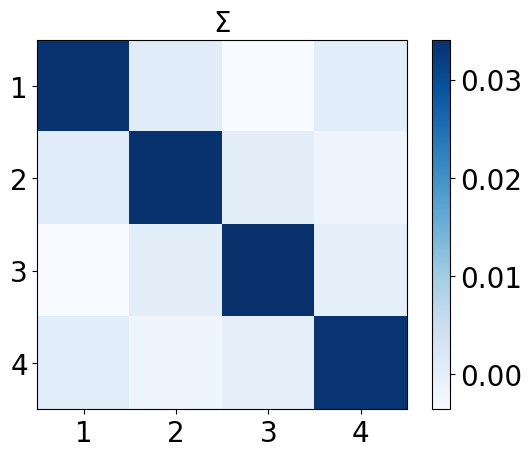

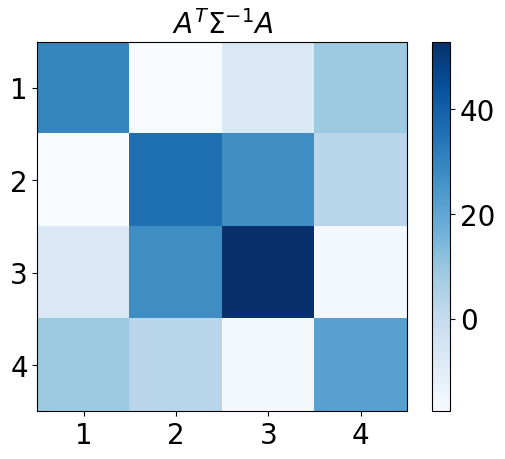

In [7]:
s,sp,l,lp=test_data
xx = s
scale = 4
func = lambda x:model.fc_mu(model.relu(model.fc2(model.relu(model.fc1(x.unsqueeze(0))))))

S_s = torch.zeros([xx.size()[0],scale])
ASA_s = torch.zeros([xx.size()[0],scale,scale])
A_s = torch.zeros([xx.size()[0],scale,scale])
Sigma_s = torch.zeros([xx.size()[0],scale,scale])

max_diff_index_s = []

for i in range(xx.size()[0]):
    Ax,L=model(xx[i,:])
    Sigma_x = torch.matmul(L, L.transpose(1, 2)) 
    (Kappa, Q) = torch.linalg.eig(Sigma_x) 
    Sigma_std = Q@torch.diag((Kappa**(1/2))[0])@torch.linalg.inv(Q)
    sigmas_matrix = Sigma_std.real[0]

    jac=jacobian(func, xx[i,:]) #use pytorch's jacobian function to obtain jacobian matrix
    A_s[i] = jac
    Sigma_s[i] = sigmas_matrix
    ASA = jac[0].T@torch.linalg.inv(sigmas_matrix)@jac[0]
    ASA_s[i] = ASA
    _,S,_ = torch.linalg.svd(ASA)
    S_s[i] = S

    rk_eps = 2

A = A_s.mean(0).detach().cpu()
Sigma = Sigma_s.mean(0).detach().cpu()
ASA = ASA_s.mean(0)

plt.imshow(Sigma,cmap = "Blues")
plt.title('$\Sigma$',fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
plt.xticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.yticks(np.arange(4), np.arange(1, 5),fontsize = 20)
#plt.savefig('./Figure/SIR_Matrix.png', dpi=600, format='png',bbox_inches = 'tight')
plt.show()
plt.close()

plt.imshow(ASA.cpu().detach().numpy(),cmap = "Blues")
plt.title('$A^T\Sigma^{-1}A$',fontsize=20)
plt.colorbar().ax.tick_params(labelsize=20)
plt.xticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.yticks(np.arange(4), np.arange(1, 5),fontsize = 20)
plt.show()
plt.close()

In [8]:
np.save("sir_sigma.npy",Sigma)
np.save("sir_AsigmaA.npy",ASA.cpu().detach().numpy())

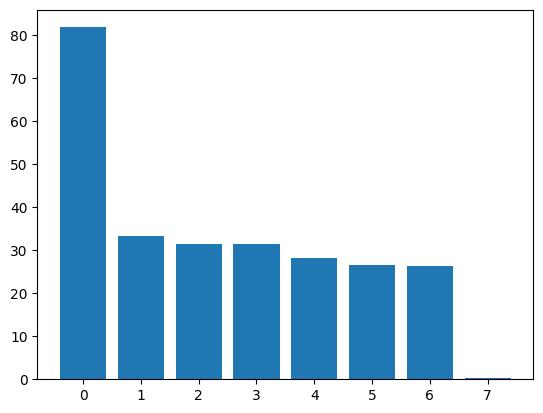

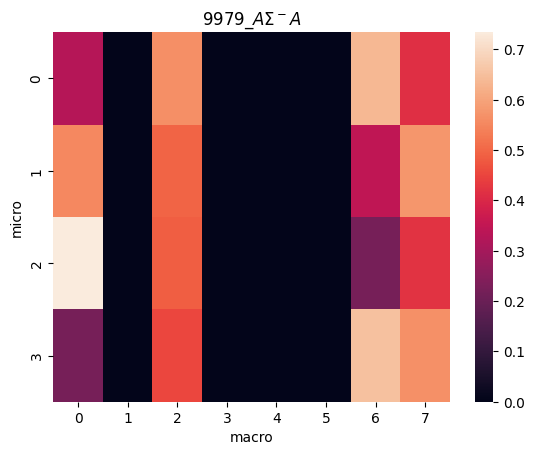

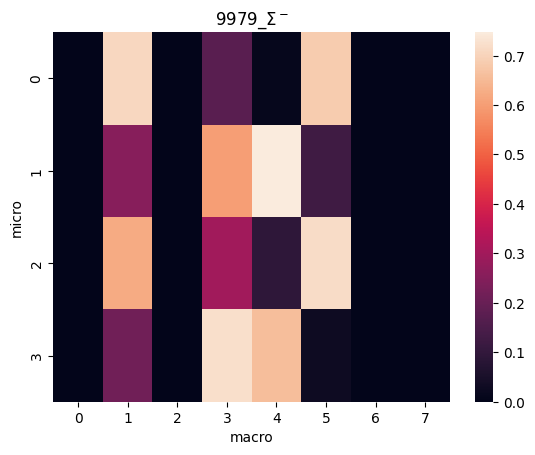

In [17]:
import seaborn as sns

def analysis_u_0(us, seq_len, dims):
    u = us
    u_col1 = u[ :seq_len*dims, :]
    u_col1 = np.abs(u_col1)
    plt.figure()
    sns.heatmap(u_col1)
    plt.xlabel('macro')
    plt.ylabel('micro')
    plt.title("{0}_$A\Sigma^- A$".format(i))
    plt.show()

    u_col2 = u[ seq_len*dims:, :]
    u_col2 = np.abs(u_col2)
    plt.figure()
    sns.heatmap(u_col2)
    plt.xlabel('macro')
    plt.ylabel('micro')
    plt.title("$\Sigma^-$")
    plt.show()

def create_block_diagonal_matrix(matrix1, matrix2):
    if matrix1.ndim != 2 or matrix2.ndim != 2:
        raise ValueError("The input matrix must be two-dimensional.")
    if matrix1.shape[0] != matrix1.shape[1] or matrix2.shape[0] != matrix2.shape[1]:
        raise ValueError("The input matrix must be a square matrix.")
    n1 = matrix1.shape[0]
    n2 = matrix2.shape[0]
    result_dim = n1 + n2
    result = np.zeros((result_dim, result_dim), dtype=matrix1.dtype)
    result[:n1, :n1] = matrix1
    result[n1:, n1:] = matrix2
    return result

block_matrix = create_block_diagonal_matrix(ASA, np.linalg.inv(Sigma))
U, S, VT = np.linalg.svd(block_matrix)

plt.figure()
plt.bar(range(len(S)), S)
plt.show()
analysis_u_0(U, seq_len=1, dims=4)


In [16]:
len(S)

8

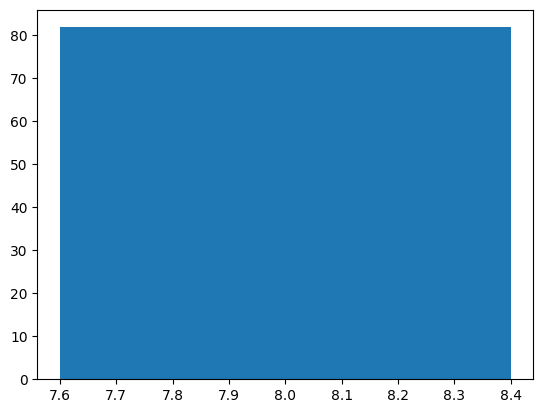

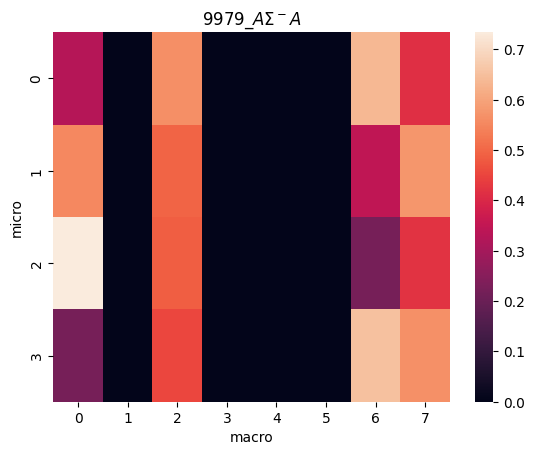

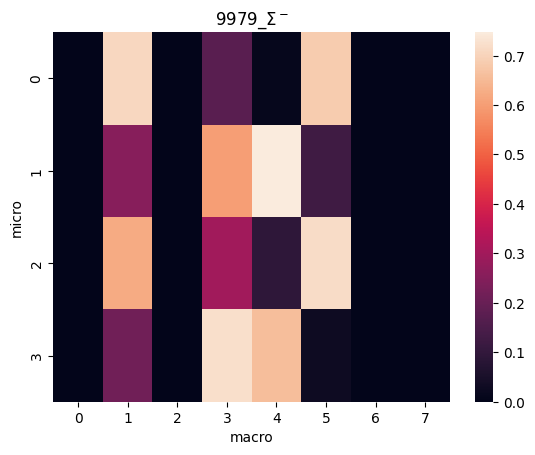

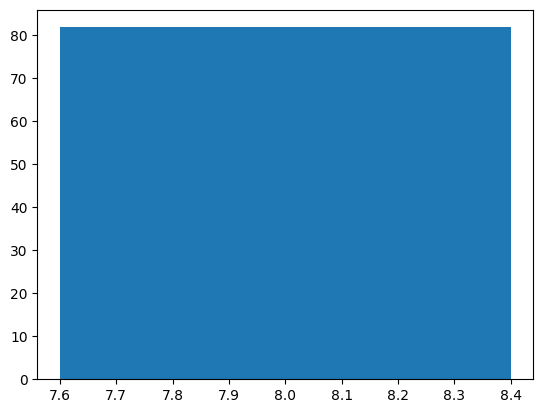

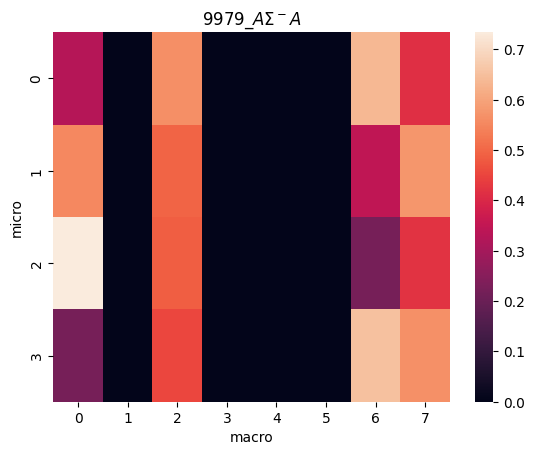

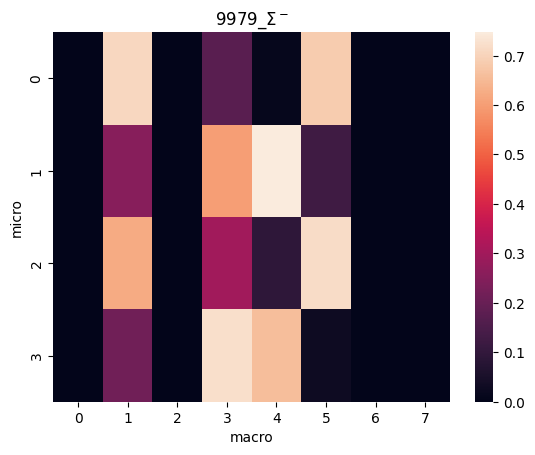

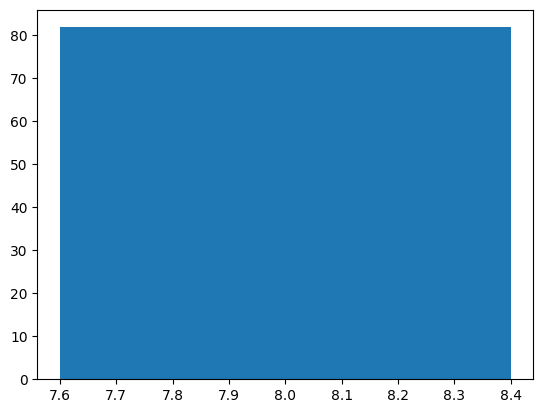

In [14]:
plt.figure()
plt.bar(len(S), S)
plt.show()